In [30]:
# 경고(warning)비표시
import warnings
warnings.filterwarnings('ignore')

In [31]:
# tbl_factory.csv : 생산공장 데이터
# tbl_warehouse.csv : 창고 데이터
# rel_cost.csv : 창고와 공장 간의 운송 비용
# tbl_transaction.csv : 2019년의 공장으로의 부품 운송 실적

###### 1. 물류 데이터 불러오기

In [32]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

plt.rc('font', family='malgun gothic')    # 한글처리
plt.rcParams['axes.unicode_minus']=False  # '- 표시

In [33]:
# 공장데이터 불러오기
factories = pd.read_csv("Data/tbl_factory.csv", index_col=0)
factories

,FCName,FCDemand,FCRegion
FCID,,,
FC00001,서울공장,28,북부
FC00002,수원공장,29,북부
FC00003,인천공장,31,북부
FC00004,대전공장,25,북부
FC00005,대구공장,21,남부
FC00006,광주공장,30,남부
FC00007,부산공장,25,남부
FC00008,울산공장,16,남부


In [34]:
# 창고데이터 불러오기
warehouses = pd.read_csv("Data/tbl_warehouse.csv", index_col=0)
warehouses

,WHName,WHSupply,WHRegion
WHID,,,
WH00001,판교창고,35,북부
WH00002,용인창고,41,북부
WH00003,수원창고,42,북부
WH00004,대전창고,60,남부
WH00005,대구창고,72,남부
WH00006,광주창고,65,남부


In [35]:
# 비용 테이블
cost = pd.read_csv("Data/rel_cost.csv", index_col=0)
cost.head(2)

,FCID,WHID,Cost
RCostID,,,
1,FC00001,WH00001,0.4
2,FC00001,WH00002,0.8


In [36]:
# 운송 실적 테이블
trans = pd.read_csv("Data/tbl_transaction.csv", index_col=0)
trans.head(2)

,TransactionDate,ToFC,FromWH,Quantity
TRID,,,,
0,2019-01-01 02:11:10,FC00004,WH00003,33
1,2019-01-01 06:12:42,FC00007,WH00006,19


In [37]:
# 운송실적 테이블에 비용 테이블을 병합

join_data = pd.merge(trans, cost,left_on=["ToFC","FromWH"], right_on=["FCID","WHID"], how="left")
join_data.head(2)

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3


In [38]:
# 공장정보 추가

join_data = pd.merge(join_data, factories, left_on="ToFC", right_on="FCID", how="left")
join_data.head(2)

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,대전공장,25,북부
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,부산공장,25,남부


In [39]:
# 창고정보 추가

join_data = pd.merge(join_data, warehouses, left_on="FromWH", right_on="WHID", how="left")
join_data.head(2)

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,대전공장,25,북부,수원창고,42,북부
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,부산공장,25,남부,광주창고,65,남부


In [40]:
# 컬럼 정리
join_data = join_data[["TransactionDate","Quantity","Cost","ToFC","FCName","FCDemand","FromWH","WHName","WHSupply","WHRegion"]]
join_data.head(2)

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,대전공장,25,WH00003,수원창고,42,북부
1,2019-01-01 06:12:42,19,1.3,FC00007,부산공장,25,WH00006,광주창고,65,남부


In [41]:
# 북부 데이터 추출

north = join_data.loc[join_data["WHRegion"]=="북부"]
north.head(2)

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,대전공장,25,WH00003,수원창고,42,북부
3,2019-01-01 07:17:06,18,1.6,FC00002,수원공장,29,WH00003,수원창고,42,북부


In [42]:
# 남부 데이터 추출

south = join_data.loc[join_data["WHRegion"]=="남부"]
south.head(2)

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
1,2019-01-01 06:12:42,19,1.3,FC00007,부산공장,25,WH00006,광주창고,65,남부
2,2019-01-01 06:32:32,31,0.9,FC00006,광주공장,30,WH00004,대전창고,60,남부


###### 2. 운송량과 비용확인

In [43]:
# 각 지사의 비용합계 계산

print("북부지사 총비용: " + str(north["Cost"].sum()) + "만원")
print("남부지사 총비용: " + str(south["Cost"].sum()) + "만원")

북부지사 총비용: 2189.3만원
남부지사 총비용: 2062.0만원


In [44]:
# 각 지사의 총 운송 개수

print("북부지사의 총 운송 개수: " + str(north["Quantity"].sum()) + "개")
print("남부지사의 총 운송 개수: " + str(south["Quantity"].sum()) + "개")

북부지사의 총 운송 개수: 49146개
남부지사의 총 운송 개수: 50214개


In [45]:
# 지사별 부품 1개당 운송비용

tmp1 =( north["Cost"].sum() / north["Quantity"].sum() ) *10000
print("북부지사의 부품 1개당 운송 비용: " + str(int(tmp1)) + "원")

tmp2 = (south["Cost"].sum() / south["Quantity"].sum()) * 10000
print("남부지사의 부품 1개당 운송 비용: " + str(int(tmp2)) + "원") 

북부지사의 부품 1개당 운송 비용: 445원
남부지사의 부품 1개당 운송 비용: 410원


###### 네트워크 그래프 기본 개념

In [46]:
!pip install networkx

In [47]:
import networkx as nx
import matplotlib.pyplot as plt

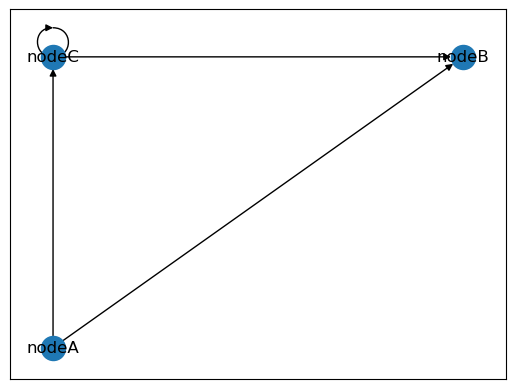

In [48]:
# 그래프 객체생성
# G = nx.Graph()   ## 무방향
G = nx.DiGraph()   ## 방향

# 노드 설정
G.add_node("nodeA")
G.add_node("nodeB")
G.add_node("nodeC")

# 엣지 설정
G.add_edge("nodeA","nodeB")
G.add_edge("nodeA","nodeC")
G.add_edge("nodeC","nodeB")
G.add_edge("nodeC","nodeC")

# 좌표 설정
pos={}
pos["nodeA"]=(0,0)
pos["nodeB"]=(1,1)
pos["nodeC"]=(0,1)

# 그리기
nx.draw_networkx(G,pos, with_labels=True)

# 표시
plt.show()

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

df_tr = pd.read_csv('data/trans_route.csv', index_col="공장")
df_pos = pd.read_csv('data/trans_route_pos.csv')

In [50]:
df_tr

,F1,F2,F3,F4
공장,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


In [51]:
df_pos

,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


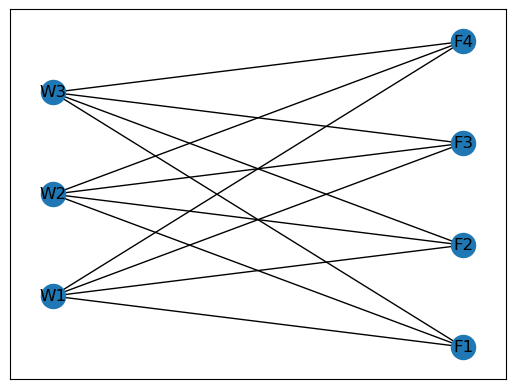

In [52]:
#객체생성
G = nx.Graph()

#노드 설정(W 3개, F 4개)
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])
    
#엣지 설정(각각의 W노드 에서 F노드 4개 모두 연결)
for i in range(0, 3):
    for j in range(3, len(df_pos.columns)):
        G.add_edge(df_pos.columns[i], df_pos.columns[j])  

        
#좌표 설정
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0],df_pos[node][1])        

    
#그리기
nx.draw_networkx(G, pos, with_labels=True)
plt.show()    

In [53]:
sy = []
size = 0.1   #가중치 값이 너무 커서 줄임
for i in range(len(df_tr.index)):
    for j in range(len(df_tr.columns)):
        sy.append(df_tr.iloc[i,j]*size)
        
sy

[1.5, 1.5, 0.0, 0.5, 0.5, 0.0, 3.0, 0.5, 1.0, 1.5, 0.2, 1.5]

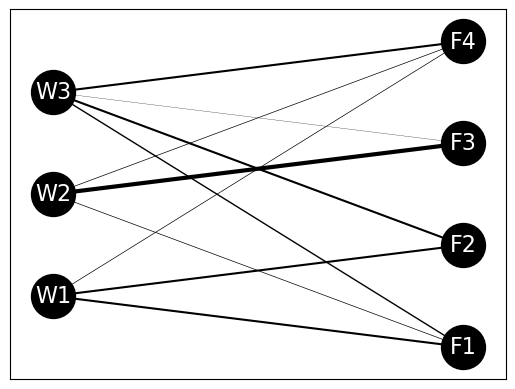

In [54]:
#그래프 다시 그리기
nx.draw_networkx(G, pos, with_labels=True,
               font_size = 16, node_size = 1000, node_color = 'k', 
               font_color= 'w', width = sy)         # width에 가중치 리스트 설정
plt.show()